In [1]:
from core import Circuit
from elements import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
G1 = Emf("G1", E=5, r=2)
R1 = Resistor("R1", R=8)
GND = Ground("GND")

c = Circuit("Simple1")
c.connect(G1.Plus, R1.Pin0)
c.connect(G1.Minus, R1.Pin1)
c.connect(GND.Pin, G1.Minus)
c.simulate(5, verbose=True, test_jac_args=None)

Nodes: 2
Terminals: 5
States: 0
Var  0 : Node 0 potential (V)
	 * Minus of EMF G1 with r=2 Ohm, E=5 V
	 * Pin1 of Resistor R1 with R=8 Ohm
	 * Pin of Ground GND
Var  1 : Node 1 potential (V)
	 * Pin0 of Resistor R1 with R=8 Ohm
	 * Plus of EMF G1 with r=2 Ohm, E=5 V
Var  2 : Current through Pin1 of Resistor R1 with R=8 Ohm (A)
Var  3 : Current through Pin of Ground GND (A)
Var  4 : Current through Pin0 of Resistor R1 with R=8 Ohm (A)
Var  5 : Current through Minus of EMF G1 with r=2 Ohm, E=5 V (A)
Var  6 : Current through Plus of EMF G1 with r=2 Ohm, E=5 V (A)
Final Run Statistics: Simple1 

 Number of steps                                 : 20
 Number of function evaluations                  : 20
 Number of Jacobian evaluations                  : 18
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 20
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver 

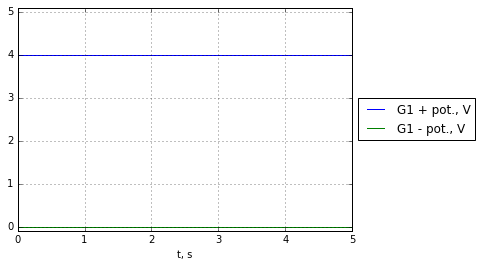

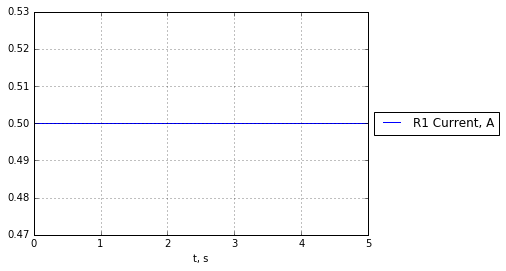

In [15]:
plt.plot(c.T, G1.Plus.V, label='G1 + pot., V')
plt.plot(c.T, G1.Minus.V, label='G1 - pot., V')
plt.xlabel('t, s')
plt.ylim(-0.1, 5.1)
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.figure()
plt.plot(c.T, R1.Pin0.I, label='R1 Current, A')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.xlabel('t, s')
plt.grid()
plt.show()

In [16]:
G1 = Emf("G1", E=5)
R1 = Resistor("R1", R=10)
L1 = Inductor("L1", L=1e-3)
GND = Ground("GND")

c2 = Circuit("RL")
c2.connect(G1.Plus, R1.Pin0)
c2.connect(R1.Pin1, L1.Pin0)
c2.connect(L1.Pin1, GND.Pin)
c2.connect(G1.Minus, GND.Pin)

t_LR = L1.L/R1.R

c2.simulate(5 * t_LR, verbose=True, test_jac_args=None)

Nodes: 3
Terminals: 7
States: 1
Var  0 : Node 0 potential (V)
	 * Plus of EMF G1 with r=0 Ohm, E=5 V
	 * Pin0 of Resistor R1 with R=10 Ohm
Var  1 : Node 1 potential (V)
	 * Pin0 of Inductor L1 with L=0.001 H
	 * Pin1 of Resistor R1 with R=10 Ohm
Var  2 : Node 2 potential (V)
	 * Pin1 of Inductor L1 with L=0.001 H
	 * Pin of Ground GND
	 * Minus of EMF G1 with r=0 Ohm, E=5 V
Var  3 : Current through Plus of EMF G1 with r=0 Ohm, E=5 V (A)
Var  4 : Current through Pin1 of Resistor R1 with R=10 Ohm (A)
Var  5 : Current through Pin0 of Resistor R1 with R=10 Ohm (A)
Var  6 : Current through Pin0 of Inductor L1 with L=0.001 H (A)
Var  7 : Current through Pin1 of Inductor L1 with L=0.001 H (A)
Var  8 : Current through Pin of Ground GND (A)
Var  9 : Current through Minus of EMF G1 with r=0 Ohm, E=5 V (A)
Var  10 : Current of Inductor L1 with L=0.001 H
Final Run Statistics: RL 

 Number of steps                                 : 81
 Number of function evaluations                  : 104
 Number o

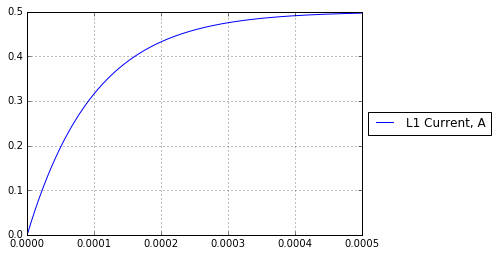

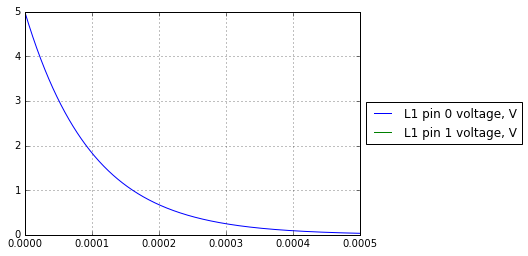

In [17]:
plt.plot(c2.T, L1.Current.val, label='L1 Current, A')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.figure()
plt.plot(c2.T, L1[0].V, label='L1 pin 0 voltage, V')
plt.plot(c2.T, L1[1].V, label='L1 pin 1 voltage, V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.show()

In [18]:
C1 = Capacitor("C1", C=1e-3, U0=1)
L1 = Inductor("L1", L=1e-3)
GND = Ground("GND")

c3 = Circuit("LC contour")
c3.connect(C1.Pin0, L1.Pin0)
c3.connect(C1.Pin1, L1.Pin1)
c3.connect(C1.Pin0, GND.Pin)

t_LC = np.sqrt(L1.L * C1.C)

c3.simulate(10*np.pi*t_LC, verbose=True, test_jac_args=None)

Nodes: 2
Terminals: 5
States: 2
Var  0 : Node 0 potential (V)
	 * Pin1 of Capacitor C1 with C=0.001 F
	 * Pin1 of Inductor L1 with L=0.001 H
Var  1 : Node 1 potential (V)
	 * Pin0 of Capacitor C1 with C=0.001 F
	 * Pin of Ground GND
	 * Pin0 of Inductor L1 with L=0.001 H
Var  2 : Current through Pin1 of Capacitor C1 with C=0.001 F (A)
Var  3 : Current through Pin of Ground GND (A)
Var  4 : Current through Pin1 of Inductor L1 with L=0.001 H (A)
Var  5 : Current through Pin0 of Capacitor C1 with C=0.001 F (A)
Var  6 : Current through Pin0 of Inductor L1 with L=0.001 H (A)
Var  7 : Voltage of Capacitor C1 with C=0.001 F
Var  8 : Current of Inductor L1 with L=0.001 H
Final Run Statistics: LC contour 

 Number of steps                                 : 398
 Number of function evaluations                  : 418
 Number of Jacobian evaluations                  : 18
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 1
 Number of nonlinear it

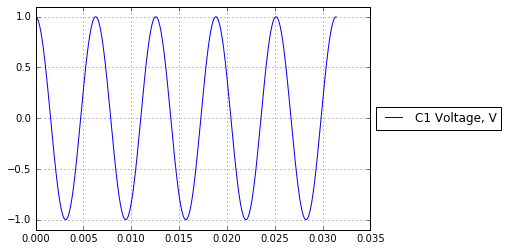

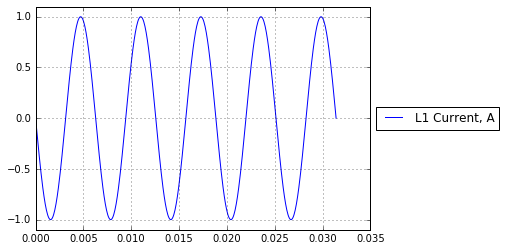

In [19]:
plt.plot(c3.T, C1.Voltage.val, label='C1 Voltage, V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.ylim(-1.1, 1.1)
plt.grid()
plt.figure()
plt.plot(c3.T, L1.Current.val, label='L1 Current, A')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.ylim(-1.1, 1.1)
plt.grid()

In [20]:
G1 = Generator("G1", E=5)
L1 = Inductor("L1", L=1)
GND = Ground("GND")

c4 = Circuit("Z=wL")
c4.connect(G1.Plus, L1.Pin0)
c4.connect(G1.Minus, L1.Pin1)
c4.connect(G1.Minus, GND.Pin)

w = G1.omega
Z = w*L1.L
print('Z =', Z)

c4.simulate(10 * np.pi / w, verbose=True, test_jac_args=None)

Z = 314.1592653589793
Nodes: 2
Terminals: 5
States: 1
Var  0 : Node 0 potential (V)
	 * Pin of Ground GND
	 * Minus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad
	 * Pin1 of Inductor L1 with L=1 H
Var  1 : Node 1 potential (V)
	 * Plus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad
	 * Pin0 of Inductor L1 with L=1 H
Var  2 : Current through Pin of Ground GND (A)
Var  3 : Current through Minus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad (A)
Var  4 : Current through Pin0 of Inductor L1 with L=1 H (A)
Var  5 : Current through Plus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad (A)
Var  6 : Current through Pin1 of Inductor L1 with L=1 H (A)
Var  7 : Current of Inductor L1 with L=1 H
Final Run Statistics: Z=wL 

 Number of steps                                 : 382
 Number of function evaluations                  : 447
 Number of Jacobian evaluations                  : 22
 Number of function eval. due to Jacobian eval.  : 

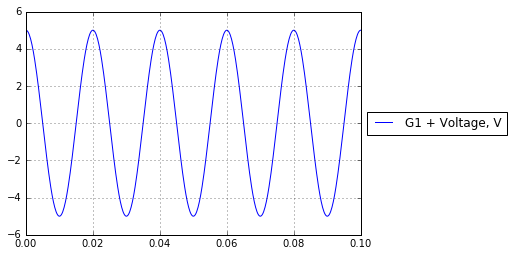

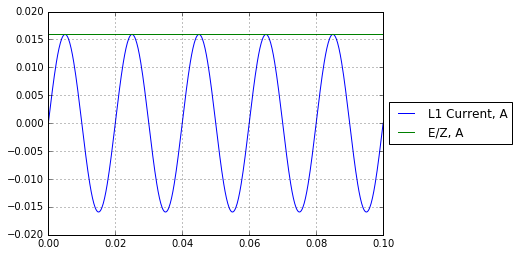

In [9]:
plt.plot(c4.T, G1.Plus.V, label='G1 + Voltage, V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.figure()
plt.plot(c4.T, L1.Current.val, label='L1 Current, A')
plt.plot(c4.T, G1.E / Z * np.ones_like(c4.T), label='E/Z, A')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()

In [21]:
G1 = Generator("G1", E=5)
L1 = Inductor("L1", L=0.1)
R1 = Resistor("R1", R=100)
VD1 = Diode("VD1", IS=1e-4, VT=0.05)
GND = Ground("GND")

c5 = Circuit("With diode")
c5.connect(G1.Plus, R1.Pin0)
c5.connect(R1.Pin1, L1.Pin0)
c5.connect(L1.Pin1, VD1.Anode)
c5.connect(G1.Minus, VD1.Cathode)
c5.connect(G1.Minus, GND.Pin)

w = G1.omega

c5.simulate(10 * np.pi / w, rtol=1e-6, verbose=True, test_jac_args=None)

Nodes: 4
Terminals: 9
States: 1
Var  0 : Node 0 potential (V)
	 * Minus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad
	 * Cathode of Diode VD1 with IS=0.0001 A, VT=0.05 V
	 * Pin of Ground GND
Var  1 : Node 1 potential (V)
	 * Pin1 of Resistor R1 with R=100 Ohm
	 * Pin0 of Inductor L1 with L=0.1 H
Var  2 : Node 2 potential (V)
	 * Pin1 of Inductor L1 with L=0.1 H
	 * Anode of Diode VD1 with IS=0.0001 A, VT=0.05 V
Var  3 : Node 3 potential (V)
	 * Pin0 of Resistor R1 with R=100 Ohm
	 * Plus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad
Var  4 : Current through Minus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad (A)
Var  5 : Current through Pin0 of Inductor L1 with L=0.1 H (A)
Var  6 : Current through Cathode of Diode VD1 with IS=0.0001 A, VT=0.05 V (A)
Var  7 : Current through Pin of Ground GND (A)
Var  8 : Current through Pin1 of Resistor R1 with R=100 Ohm (A)
Var  9 : Current through Pin1 of Inductor L1 with L=0.1 H (A)
Var  10 : Curr

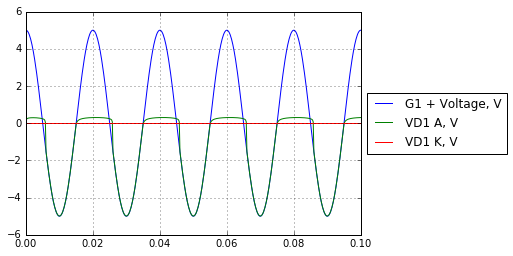

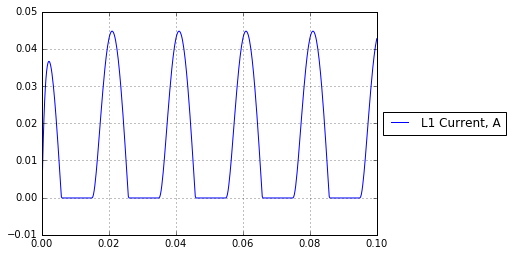

In [11]:
plt.plot(c5.T, G1.Plus.V, label='G1 + Voltage, V')
plt.plot(c5.T, VD1.Anode.V, label='VD1 A, V')
plt.plot(c5.T, VD1.Cathode.V, label='VD1 K, V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.figure()
plt.plot(c5.T, L1.Pin0.I, label='L1 Current, A')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()

In [22]:
G1 = Generator("G1", E=5)
IS = 0.001
VT = 0.5
R1 = Resistor("R1", R=1e5)
R2 = Resistor("R2", R=1e5)
VD1 = Diode("VD1", IS=IS, VT=VT)
VD2 = Diode("VD2", IS=IS, VT=VT)
VD3 = Diode("VD3", IS=IS, VT=VT)
VD4 = Diode("VD4", IS=IS, VT=VT)
C1 = Capacitor("C1", C=1000e-6)
LOAD = Resistor("LOAD", R=1e4)
GND = Ground("GND")

c5 = Circuit("Diode bridge")
c5.connect(G1.Plus, VD1.Anode)
c5.connect(G1.Plus, VD2.Cathode)
c5.connect(G1.Plus, R1.Pin1)

c5.connect(G1.Minus, VD3.Anode)
c5.connect(G1.Minus, VD4.Cathode)
c5.connect(G1.Minus, R2.Pin1)

c5.connect(R1.Pin0, R2.Pin0)
c5.connect(R1.Pin0, GND.Pin)

c5.connect(LOAD.Pin0, VD1.Cathode)
c5.connect(LOAD.Pin0, VD3.Cathode)
c5.connect(LOAD.Pin1, VD2.Anode)
c5.connect(LOAD.Pin1, VD4.Anode)
c5.connect(LOAD.Pin0, C1.Pin1)
c5.connect(LOAD.Pin1, C1.Pin0)

w = G1.omega

c5.simulate(100 * np.pi / w, rtol=1e-6, verbose=True, test_jac_args=None)

Nodes: 5
Terminals: 19
States: 1
Var  0 : Node 0 potential (V)
	 * Pin of Ground GND
	 * Pin0 of Resistor R1 with R=100000 Ohm
	 * Pin0 of Resistor R2 with R=100000 Ohm
Var  1 : Node 1 potential (V)
	 * Anode of Diode VD3 with IS=0.001 A, VT=0.5 V
	 * Pin1 of Resistor R2 with R=100000 Ohm
	 * Minus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad
	 * Cathode of Diode VD4 with IS=0.001 A, VT=0.5 V
Var  2 : Node 2 potential (V)
	 * Anode of Diode VD2 with IS=0.001 A, VT=0.5 V
	 * Pin0 of Capacitor C1 with C=0.001 F
	 * Anode of Diode VD4 with IS=0.001 A, VT=0.5 V
	 * Pin1 of Resistor LOAD with R=10000 Ohm
Var  3 : Node 3 potential (V)
	 * Pin1 of Resistor R1 with R=100000 Ohm
	 * Anode of Diode VD1 with IS=0.001 A, VT=0.5 V
	 * Cathode of Diode VD2 with IS=0.001 A, VT=0.5 V
	 * Plus of Generator G1 with r=0 Ohm, E=5 V, F=314.159 rad/s, Ph=0 rad
Var  4 : Node 4 potential (V)
	 * Cathode of Diode VD3 with IS=0.001 A, VT=0.5 V
	 * Pin0 of Resistor LOAD with R=10000 Ohm
	 * Pin

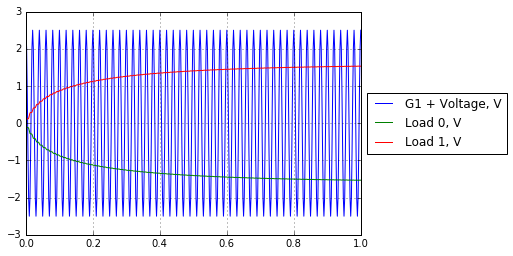

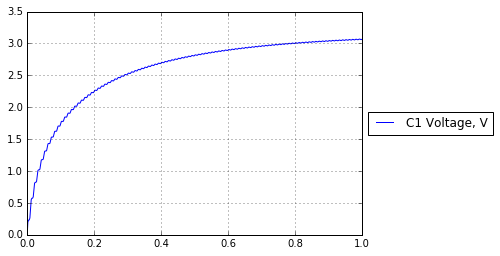

In [23]:
plt.plot(c5.T, G1.Plus.V, label='G1 + Voltage, V')
plt.plot(c5.T, LOAD.Pin1.V, label='Load 0, V')
plt.plot(c5.T, LOAD.Pin0.V, label='Load 1, V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.figure()
plt.plot(c5.T, C1.Voltage.val, label='C1 Voltage, V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()